# <span style="color:Red">Measuring Pedestrian Accessibility</span>

Walkable neighborhoods are great for health, happiness and economic growth. Cities around the world that want to draw a talented young workforce increasingly focused on creating a good pedestrian experience. How could we measure and map walkability using data science tools?

We will be dealing with proximity analysis along a road network. Measuring the density of amenities like shops, office and bus stations ‘as the crow flies’ is trivial.

### <span style="color:green">Load required Libraries.</span>

In [1]:
import pandana, time, os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline

### <span style="color:green">Set Configurations.</span>

In [2]:
amenities = ['school', 'restaurant', 'park']
distance = 2500
num_pois = 10
num_categories = len(amenities) +1 # one for each amenity, plus one extra for all of them combined

# Bounding Box
bbox = [-1.2961960539842097, 36.7474434861849559, -1.1842747463042029, 36.9059986720649675] # lat-lon for Nairobi County

In [3]:
# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = f'C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/network_{bbox}.h5'
# poi_filename = 'C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/amenities/amenities.csv'

poi_filename = 'C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [4]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0] / bbox[3] - bbox[1])
fig_kwargs = {'facecolor': 'w',
             'figsize': (10, 10)}

# keyword arguments to pass for scatter plot
plot_kwargs = {'s': 5,
              'alpha': 0.9,
              'cmap': 'viridis_r',
              'edgecolor': 'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# Keywords to pass for hex bin plots
hex_plot_kwargs = {'gridsize': 60,
                  'alpha': 0.9,
                  'cmap': 'viridis_r',
                  'edgecolor': 'none'}

# Keyword arguments to pass to basemap
bmap_kwargs = {}

# Keywords arguments to pass to make the colorbar
cbar_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

### <span style="color:green">Download points of interest (POIs) and network data from OSM.</span>

First get the points of interest - either load an existing set for the specified amenities and bounding box from CSV, or get it from the OSM API.

In [5]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # if a point-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:
    # otherwise, query the OSM API for the specified amenities within the bounding box
    osm_tags = {"amenity": True}
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)

    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'download from OSM'

print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].tail()

1,373 POIs loaded from CSV in 0.08 seconds


,amenity,name,lat,lon
1368,restaurant,Enjoyuan Chinese Restaurant,-1.229087,36.807469
1369,restaurant,Escada Restaurant,-1.267207,36.799967
1370,restaurant,Chiromo mess,-1.271496,36.803699
1371,restaurant,Taran Hotel and resturant,-1.274705,36.849444
1372,restaurant,Ice cream,-1.287537,36.825446


In [6]:
type(pois)

pandas.core.frame.DataFrame

In [7]:
# how many points of interest of each type of amenity did we retrieve?
pois['amenity'].value_counts()

school        778
restaurant    595
Name: amenity, dtype: int64

Next get the street network data - either load an existing dataset for the specified bounding box from HDF5, or get it fresh from the OSM API.

In [8]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 25,151 nodes loaded from HDF5 in 2.79 secs


### <span style="color:green">Calculate Accessibility to Any Amenity we retrieved.</span>

In [9]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [10]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [11]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [12]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

25,151 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
30030168,192.348007,340.260010,465.489014,526.526978,545.094971,556.184998,556.184998,590.755981,602.348022,621.888977
30030169,322.359009,396.515991,426.174011,426.174011,460.744995,470.270996,472.337006,507.675995,544.197021,544.197021
30030170,58.730999,58.730999,58.730999,65.143997,123.723999,169.996994,255.259995,255.679993,255.679993,281.454987
30030172,362.218994,578.604004,638.411987,660.950989,717.021973,800.497009,806.072998,844.664001,844.664001,1020.338013
30030176,249.893997,466.278992,526.086975,548.625977,604.697021,688.171997,693.747986,732.338989,732.338989,908.013000


### <span style="color:green">Plot Accessibility from each node to any amenity </span>

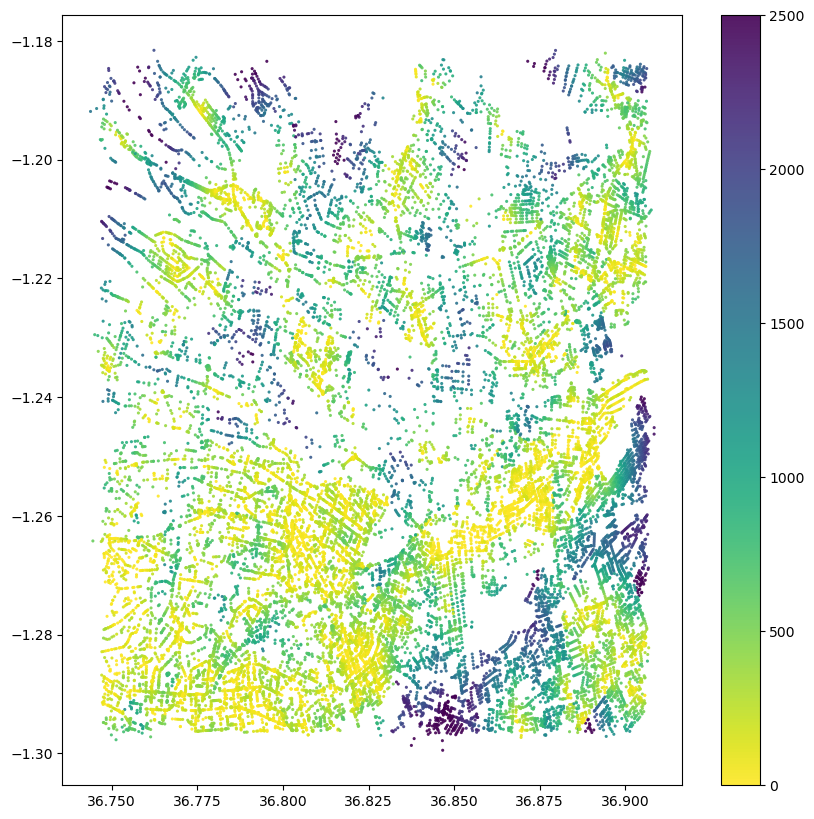

In [13]:
# distance to the nearest amenity of any type
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance(m) to the nearest amenity around Karura Forest Neighborhood/Nairobi', fontsize=15)
fig.savefig('C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/Figures/accessibility-all-amenities.svg', dpi=200, bbox_inches='tight')

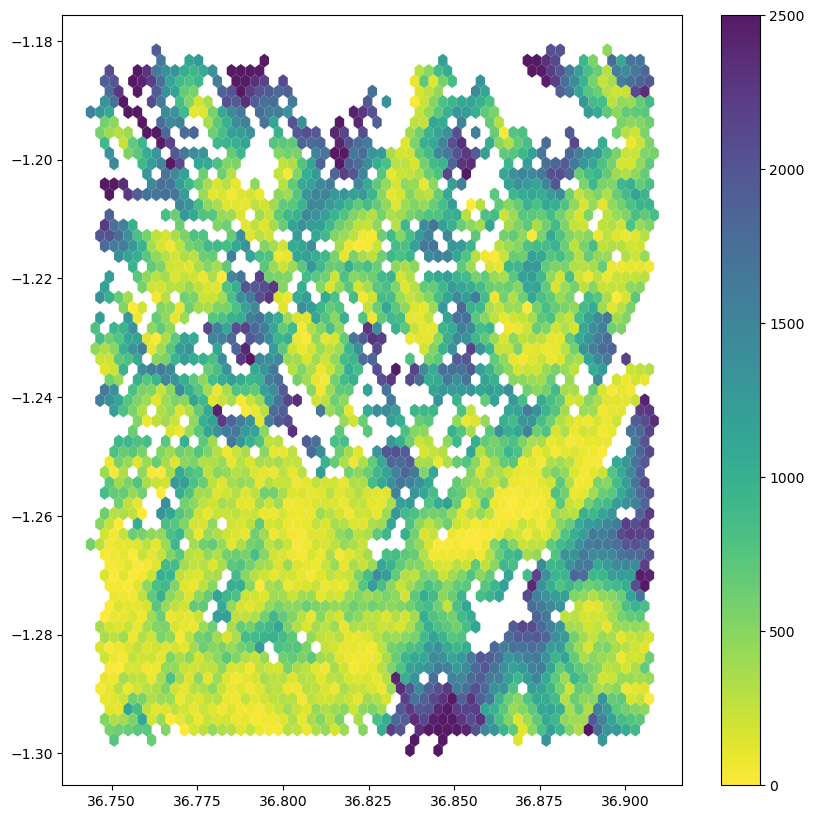

In [14]:
# distance to the nearest amenity of any type, as hexbins
fig, ax = network.plot(all_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance(m) to the nearest amenity around Karura Forest Neighborhood/Nairobi', fontsize=15)
fig.savefig('C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/Figures/accessibility-all-hexbin-amenities.png', dpi=200, bbox_inches='tight')

### <span style="color:green">Calculate and plot accessibility separately for each amenity type </span>

The amenity types specified at the beginning area: restaurants, parks, and schools

In [15]:
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in ['school', 'restaurant']:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()


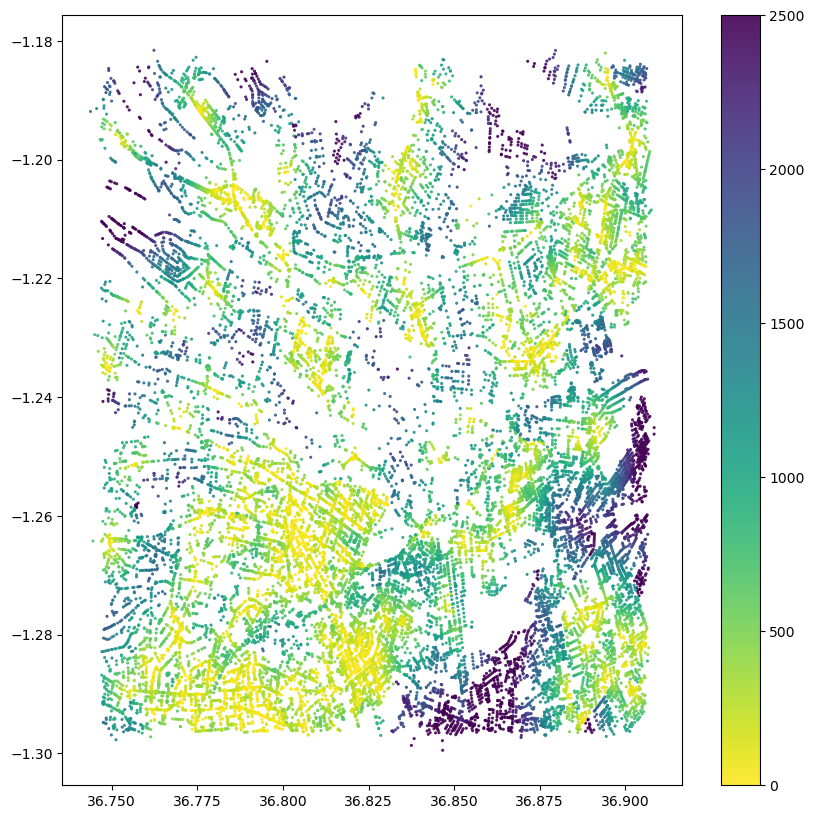

In [16]:
# distance to the nearest restaurant
restaurant_access = network.nearest_pois(distance=distance, category='restaurant', num_pois=num_pois)
fig, ax = network.plot(restaurant_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance(m) to nearest restaurant around Karura Forest Neighborhood/Nairobi', fontsize=15)
fig.savefig('C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/Figures/accessibility-restaurant-karura-neib.png', dpi=200, bbox_inches='tight')

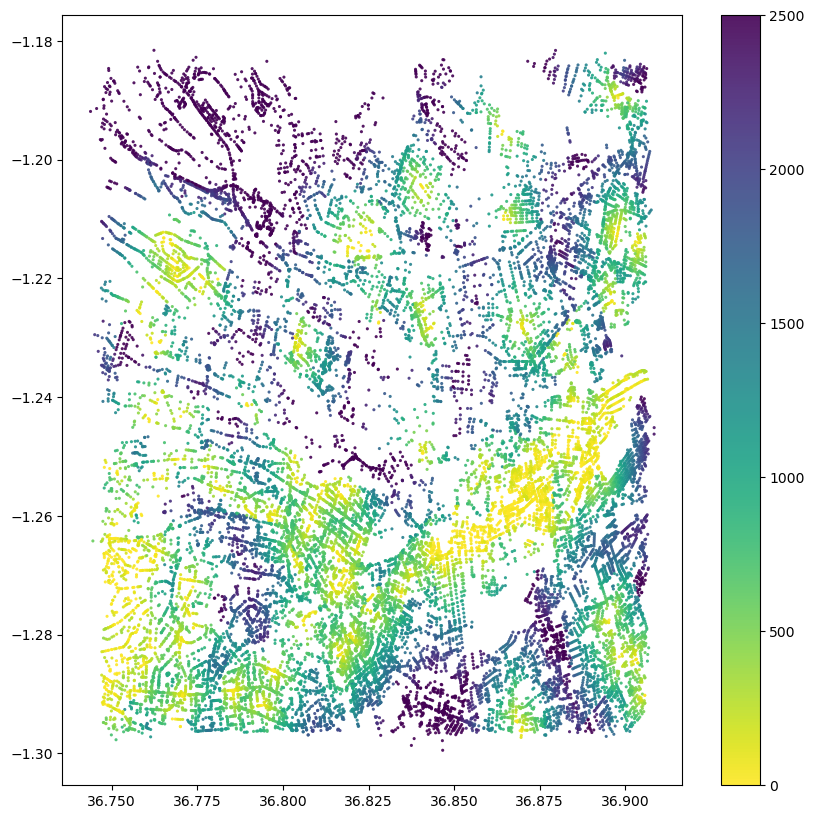

In [17]:
# distance to the nearest school
school_access = network.nearest_pois(distance=distance, category='school', num_pois=num_pois)
fig, ax = network.plot(school_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance(m) to nearest school around Karura Forest Neighborhood/Nairobi', fontsize=15)
fig.savefig('C:/Users/Dell/OneDrive/Desktop/urban-green-spaces/Proximity/Figures/accessibility-school-karura-neib.png', dpi=200, bbox_inches='tight')